In [ ]:
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms, models
import torch.nn as nn
import torch.nn.functional as F
from torchvision.ops import nms, roi_align

In [ ]:
import sys
import os
project_root= os.getcwd() + "/../"
src_path= os.path.join(project_root, 'src')
if src_path not in sys.path:
    sys.path.append(src_path)
from config import data_dir, images_train_dir, images_val_dir, labels_2_dir, artifacts_dir
import config
from preprocessing import FaceDataset, filter_valid_bboxes, calculate_iou, create_bbox_deltas, apply_deltas_to_boxes, clamp_boxes_to_img_boundary

from utils import visualize_anchors_and_gt
from models import RPN

In [ ]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("fareselmenshawii/face-detection-dataset")

# print("Path to dataset files:", path)

/home/atlas/playground/FasterRCNNFaceDetection/face_detection_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 4.43G/4.43G [04:31<00:00, 17.5MB/s]

Extracting files...


Path to dataset files: /home/atlas/.cache/kagglehub/datasets/fareselmenshawii/face-detection-dataset/versions/3


In [4]:
class RoIHead(nn.Module):
    def __init__(self,
                 in_channels= 512,
                 num_classes= 1,
                 roi_output_size= 14,
                 fc_hidden= 2048,
                 dropout_rate= 0.5):
        super(RoIHead, self).__init__()
        self.num_classes= num_classes
        self.roi_output_size= roi_output_size

        self.fc= nn.Sequential(
            nn.AdaptiveAvgPool2d(roi_output_size),
            nn.Flatten(),
            nn.Linear(in_channels * roi_output_size * roi_output_size, fc_hidden),
            nn.ReLU(inplace= True),
            nn.Dropout(dropout_rate),
            nn.Linear(fc_hidden, fc_hidden),
            nn.ReLU(inplace= True),
            nn.Dropout(dropout_rate)
        )
        self.cls_head= nn.Linear(fc_hidden, num_classes + 1)
        self.reg_head= nn.Linear(fc_hidden, (num_classes + 1) * 4)

        for m in [self.cls_head, self.reg_head]:
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
        nn.init.normal_(self.cls_head.weight, std= 0.01)
        nn.init.normal_(self.reg_head.weight, std= 0.001)
    def _empty_forward(self, device):
        return {
            'cls_logits': torch.empty(0, self.num_classes + 1, device=device),
            'bbox_deltas': torch.empty(0, (self.num_classes + 1) * 4, device=device),
            'cls_loss': torch.tensor(0.0, device=device, requires_grad=True),
            'reg_loss': torch.tensor(0.0, device=device, requires_grad=True)
        }
    def forward(self, features, proposals, image_shapes, gt_boxes= None):
        device= features.device
        B, C, feat_H, feat_W= features.shape
        img_H, img_W= image_shapes[0]
        spatial_scale= feat_H / img_H

        if gt_boxes is not None:
            sampled_proposals, sampled_labels, sampled_targets= self.sample_rois_for_training(proposals, gt_boxes)
            if len(sampled_proposals) == 0:
                return self._empty_forward(device)


            rois= []
            roi_batch_idx= []
            # 1. Convert proposals to RoI-Align format
            for b, prop in enumerate(sampled_proposals):
                rois.append(prop)
                roi_batch_idx.append(torch.full((prop.shape[0],), b, device= device, dtype= torch.float))

        else:
            rois= []
            roi_batch_idx= []
            for b, prop in enumerate(proposals):
                if prop.numel() > 0:
                    rois.append(prop)
                    roi_batch_idx.append(torch.full((prop.shape[0],), b, device= device, dtype= torch.float))

        if len(rois) == 0:
            return self._empty_forward(device)

        rois= torch.cat(rois, dim= 0)
        batch_idx= torch.cat(roi_batch_idx)
        # 3. RoI-Align
        roi_features= roi_align(
            features,
            torch.cat([batch_idx.unsqueeze(1), rois], dim= 1),
            output_size= self.roi_output_size,
            spatial_scale= spatial_scale,
            sampling_ratio= -1
        )

        x= self.fc(roi_features)
        cls_logits= self.cls_head(x)
        bbox_deltas= self.reg_head(x)

        losses= {}
        if gt_boxes is not None:
            cls_loss, reg_loss= self.compute_losses(cls_logits, bbox_deltas, sampled_labels, sampled_targets)
            losses= dict(cls_loss= cls_loss, reg_loss= reg_loss)

        return dict(cls_logits= cls_logits,
                    bbox_deltas= bbox_deltas,
                    **losses)

    def compute_losses(self, cls_logits, bbox_deltas, sampled_labels, sampled_targets):
        device= cls_logits.device

        if len(sampled_labels) == 0:
            return torch.tensor(0.0, device= device, requires_grad= True), torch.tensor(0.0, device= device, requires_grad= True)

        labels= torch.cat(sampled_labels)
        targets= torch.cat(sampled_targets)

        cls_loss= F.cross_entropy(cls_logits, labels, label_smoothing= 0.1)

        pos_mask= labels == 1

        if pos_mask.sum() > 0:
            pos_bbox_deltas= bbox_deltas[pos_mask]
            pos_targets= targets[pos_mask]

            pos_bbox_deltas= pos_bbox_deltas.view(-1, self.num_classes + 1, 4)[:, 1, :]

            reg_loss= F.smooth_l1_loss(pos_bbox_deltas, pos_targets, beta= 1.0)
        else:
            reg_loss= torch.tensor(0.0, device= device, requires_grad= True)
        return cls_loss, reg_loss

    def sample_rois_for_training(self, proposals, gt_boxes,
                                 batch_size_per_image= 512,
                                 positive_fraction= 0.4,
                                 fg_iou_thresh= 0.7,
                                 bg_iou_thresh_hi= 0.3,
                                 bg_iou_thresh_lo= 0.05):
        sampled_proposals= []
        sampled_labels= []
        sampled_targets= []

        for b, (props, gt) in enumerate(zip(proposals, gt_boxes)):
            valid_gt= filter_valid_bboxes(gt)
            if props.numel() == 0 or valid_gt.numel() == 0:
                continue
            iou_mat= calculate_iou(props, valid_gt)
            max_ious, gt_assignment= iou_mat.max(dim= 1)

            labels= torch.zeros(props.shape[0], dtype= torch.long, device= props.device)
            fg_mask= max_ious >= fg_iou_thresh
            labels[fg_mask]= 1

            bg_mask= (max_ious < bg_iou_thresh_hi) & (max_ious >= bg_iou_thresh_lo)
            labels[bg_mask]= 0

            ignore_mask= ~(fg_mask | bg_mask)
            labels[ignore_mask]= -1

            fg_inds= torch.where(labels == 1)[0]
            bg_inds= torch.where(labels == 0)[0]

            num_fg= min(int(batch_size_per_image * positive_fraction), len(fg_inds))
            num_bg= min(batch_size_per_image - num_fg, len(bg_inds))


            if len(fg_inds) > num_fg:
                fg_inds= fg_inds[torch.randperm(len(fg_inds))[:num_fg]]
            if len(bg_inds) > num_bg:
                bg_inds= bg_inds[torch.randperm(len(bg_inds))[:num_bg]]

            keep_inds= torch.cat([fg_inds, bg_inds])
            sampled_proposals.append(props[keep_inds])
            sampled_labels.append(labels[keep_inds])

            if len(fg_inds) > 0:
                fg_props= props[keep_inds[:len(fg_inds)]]
                matched_gt= valid_gt[gt_assignment[keep_inds[:len(fg_inds)]]]
                reg_targets= create_bbox_deltas(fg_props, matched_gt)

                full_targets= torch.zeros(len(keep_inds), 4, device= props.device)
                full_targets[:len(fg_inds)]= reg_targets
                sampled_targets.append(full_targets)
            else:
                sampled_targets.append(torch.zeros((len(keep_inds), 4), device= props.device))

        return sampled_proposals, sampled_labels, sampled_targets

In [5]:
def roi_collate(batch):
    return batch

In [6]:
valid_img_extensions= ('.jpg', '.jpeg', '.png')
all_images= [
    img for img in os.listdir(images_train_dir)
    if img.lower().endswith(valid_img_extensions) and os.path.exists(os.path.join(labels_2_dir, img.rsplit('.', 1)[0] + ".txt"))
]
all_images[1:5]

['3ef14cf5c422a12f.jpg',
 'd828e8f156922f21.jpg',
 '95508519abad76fa.jpg',
 '215e3c168ab12630.jpg']

In [7]:
train_images, val_images= train_test_split(all_images, test_size= 0.15, random_state= 42)
transforms= transforms.Compose([
    transforms.Resize((512,512)),
    transforms.Normalize(mean= [0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
train_dataset= FaceDataset(image_dir= images_train_dir, label_dir= labels_2_dir, image_list= train_images, max_boxes= 50, transform= transforms)
val_dataset= FaceDataset(image_dir= images_train_dir, label_dir= labels_2_dir, image_list= val_images, max_boxes= 50, transform= transforms)
train_loader= DataLoader(train_dataset, batch_size= config.BATCH_SIZE, shuffle= True, collate_fn= roi_collate)
val_loader= DataLoader(val_dataset, batch_size= config.BATCH_SIZE, shuffle= False, collate_fn= roi_collate)

In [8]:
device= torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vgg16= models.vgg16(pretrained= True)
backbone= vgg16.features[:-1]
for p in backbone.parameters():
    p.requires_grad= False
rpn_model= RPN()
rpn_model.load_state_dict(torch.load(artifacts_dir + "rpn_5epchs_vgg16bb_s2_r1_lr1e-4_wghts_bs16.pth"))
for p in rpn_model.parameters():
    p.requires_grad= False
roi_head= RoIHead(in_channels= 512, num_classes= 1).to(device)
optimizer= torch.optim.Adam(roi_head.parameters(), lr= config.LEARNING_RATE)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
@torch.no_grad()
def generate_proposals(images, image_shapes):
    features= backbone(images)
    with torch.cuda.amp.autocast():
      rpn_out= rpn_model(feat= features, image_shapes= image_shapes, gt_boxes= None)
    proposals= [p[:512] for p in rpn_out['proposals']]
    return proposals, features

In [10]:
def compute_map(pred_boxes, pred_scores, gt_boxes, iou_thresh=0.4, score_thresh=0.5):
    """
    Compute mAP for object detection
    """
    all_ap = []
    total_tp = 0
    total_fp = 0
    total_gt = 0

    for p_boxes, p_scores, g_boxes in zip(pred_boxes, pred_scores, gt_boxes):
        valid_gt = filter_valid_bboxes(g_boxes)
        total_gt += len(valid_gt)

        # Skip if no ground truth
        if valid_gt.numel() == 0:
            if p_boxes.numel() > 0:
                # All predictions are false positives
                score_mask = p_scores > score_thresh
                total_fp += score_mask.sum().item()
            continue

        # Skip if no predictions
        if p_boxes.numel() == 0:
            continue

        # Filter predictions by score threshold
        score_mask = p_scores > score_thresh
        p_boxes = p_boxes[score_mask]
        p_scores = p_scores[score_mask]

        if p_boxes.numel() == 0:
            continue

        # Sort predictions by score (descending)
        order = torch.argsort(p_scores, descending=True)
        p_boxes = p_boxes[order]
        p_scores = p_scores[order]

        # Initialize arrays
        true_pos = torch.zeros(len(p_boxes), device=p_boxes.device)
        false_pos = torch.zeros(len(p_boxes), device=p_boxes.device)
        detected = torch.zeros(len(valid_gt), dtype=torch.bool, device=valid_gt.device)

        # For each prediction
        for i, pb in enumerate(p_boxes):
            # Calculate IoU with all GT boxes
            iou_mat = calculate_iou(pb.unsqueeze(0), valid_gt)  # Shape: (1, num_gt)

            if iou_mat.numel() > 0:
                best_iou, best_idx = iou_mat.max(dim=1)  # max along GT dimension
                best_iou = best_iou.item()
                best_idx = best_idx.item()

                if best_iou >= iou_thresh and not detected[best_idx]:
                    true_pos[i] = 1
                    detected[best_idx] = True
                else:
                    false_pos[i] = 1
            else:
                false_pos[i] = 1

        # Calculate cumulative TP and FP
        cumulative_tp = torch.cumsum(true_pos, dim=0)
        cumulative_fp = torch.cumsum(false_pos, dim=0)

        # Calculate precision and recall
        precision = cumulative_tp / (cumulative_tp + cumulative_fp + 1e-8)
        recall = cumulative_tp / (len(valid_gt) + 1e-8)

        # Calculate AP using 11-point interpolation or all-point interpolation
        ap = compute_ap(precision, recall)
        all_ap.append(ap)

        # Accumulate totals for overall metrics
        total_tp += true_pos.sum().item()
        total_fp += false_pos.sum().item()

    # Calculate overall metrics
    overall_precision = total_tp / (total_tp + total_fp + 1e-8) if (total_tp + total_fp) > 0 else 0.0
    overall_recall = total_tp / (total_gt + 1e-8) if total_gt > 0 else 0.0
    map_score = sum(all_ap) / len(all_ap) if all_ap else 0.0

    return {
        'precision': overall_precision,
        'recall': overall_recall,
        'map': map_score,
        'num_images': len(pred_boxes)
    }

def compute_ap(precision, recall):
    """
    Compute Average Precision using all-point interpolation
    """
    # Add boundary points
    mrec = torch.cat([torch.tensor([0.0], device=recall.device), recall, torch.tensor([1.0], device=recall.device)])
    mpre = torch.cat([torch.tensor([0.0], device=precision.device), precision, torch.tensor([0.0], device=precision.device)])

    # Make precision monotonically decreasing
    for i in range(len(mpre) - 2, -1, -1):
        mpre[i] = torch.max(mpre[i], mpre[i + 1])

    # Find indices where recall changes
    indices = torch.where(mrec[1:] != mrec[:-1])[0] + 1

    # Calculate AP
    ap = torch.sum((mrec[indices] - mrec[indices - 1]) * mpre[indices])
    return ap.item()
@torch.no_grad()
def evaluate_model(model, backbone, rpn_model, val_loader, device):
    """
    Evaluate the model and return predictions for mAP calculation
    """
    model.eval()
    all_pred_boxes = []
    all_pred_scores = []
    all_gt_boxes = []

    for batch in val_loader:
        images = torch.stack([b['image'] for b in batch]).to(device)
        gt_boxes = [b['boxes'].to(device) for b in batch]

        B, _, H, W = images.shape
        image_shapes = [(H, W)] * B

        # Generate proposals
        features = backbone(images)
        rpn_out = rpn_model(feat=features, image_shapes=image_shapes, gt_boxes=None)
        proposals = rpn_out['proposals']

        # Skip if no proposals
        if len(proposals) == 0 or all(p.numel() == 0 for p in proposals):
            all_pred_boxes.extend([torch.empty(0, 4, device=device)] * B)
            all_pred_scores.extend([torch.empty(0, device=device)] * B)
            all_gt_boxes.extend(gt_boxes)
            continue

        # Forward through RoI head
        roi_out = model(features, proposals, image_shapes, gt_boxes=None)
        cls_logits = roi_out['cls_logits']
        bbox_deltas = roi_out['bbox_deltas']

        # Convert to predictions
        cls_probs = torch.softmax(cls_logits, dim=1)[:, 1]  # Foreground probability

        # Apply bbox deltas to proposals
        all_proposals = torch.cat(proposals, dim=0)
        bbox_deltas_reshaped = bbox_deltas.view(-1, model.num_classes + 1, 4)[:, 1, :]  # Take foreground deltas
        pred_boxes = apply_deltas_to_boxes(all_proposals, bbox_deltas_reshaped)
        pred_boxes = clamp_boxes_to_img_boundary(pred_boxes, image_shapes[0])

        # Split predictions back by batch
        idx = 0
        for b in range(B):
            n_proposals = proposals[b].shape[0]

            if n_proposals == 0:
                all_pred_boxes.append(torch.empty(0, 4, device=device))
                all_pred_scores.append(torch.empty(0, device=device))
            else:
                b_boxes = pred_boxes[idx:idx + n_proposals]
                b_scores = cls_probs[idx:idx + n_proposals]

                # Apply NMS
                if b_boxes.numel() > 0 and b_scores.numel() > 0:
                    score_thresh = 0.5  # Lower threshold for evaluation
                    score_mask = b_scores > score_thresh
                    if score_mask.any():
                        b_boxes = b_boxes[score_mask]
                        b_scores = b_scores[score_mask]

                        keep = nms(b_boxes, b_scores, iou_threshold=0.3)
                        all_pred_boxes.append(b_boxes[keep])
                        all_pred_scores.append(b_scores[keep])
                    else:
                        all_pred_boxes.append(torch.empty(0, 4, device=device))
                        all_pred_scores.append(torch.empty(0, device=device))
                else:
                    all_pred_boxes.append(torch.empty(0, 4, device=device))
                    all_pred_scores.append(torch.empty(0, device=device))

            idx += n_proposals
            all_gt_boxes.append(gt_boxes[b])

    return all_pred_boxes, all_pred_scores, all_gt_boxes

In [11]:
# Training loop with corrected validation
rpn_model.to(device)
backbone.to(device)
train_loss_history = []
val_loss_history = []

for epoch in range(config.NUM_EPOCHS):
    # Training phase
    roi_head.train()
    epoch_cls, epoch_reg, epoch_total_loss = 0.0, 0.0, 0.0
    num_batches_epoch = 0

    for batch in train_loader:
        images = torch.stack([b['image'] for b in batch]).to(device)
        gt_boxes = [b['boxes'].to(device) for b in batch]

        B, _, H, W = images.shape
        image_shapes = [(H, W)] * B
        proposals, features = generate_proposals(images, image_shapes)

        roi_out = roi_head(features, proposals, image_shapes, gt_boxes)
        cls_loss = roi_out['cls_loss']
        reg_loss = roi_out['reg_loss']
        loss = cls_loss + reg_loss

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(roi_head.parameters(), max_norm=1.0)  # Gradient clipping
        optimizer.step()

        epoch_cls += cls_loss.item()
        epoch_reg += reg_loss.item()
        epoch_total_loss += loss.item()
        num_batches_epoch += 1

    # Average losses
    epoch_cls /= num_batches_epoch
    epoch_reg /= num_batches_epoch
    epoch_total_loss /= num_batches_epoch
    train_loss_history.append(epoch_total_loss)

    # Validation phase
    roi_head.eval()
    val_cls_epoch, val_reg_epoch = 0.0, 0.0
    val_num_batches = 0

    # Compute validation losses
    with torch.no_grad():
        for batch in val_loader:  # Limit validation batches for speed
            images = torch.stack([b['image'] for b in batch]).to(device)
            gt_boxes = [b['boxes'].to(device) for b in batch]

            B, _, H, W = images.shape
            image_shapes = [(H, W)] * B
            proposals, features = generate_proposals(images, image_shapes)

            roi_out = roi_head(features, proposals, image_shapes, gt_boxes)
            val_cls_epoch += roi_out['cls_loss'].item()
            val_reg_epoch += roi_out['reg_loss'].item()
            val_num_batches += 1

    val_cls_epoch /= val_num_batches
    val_reg_epoch /= val_num_batches
    val_total_loss = val_cls_epoch + val_reg_epoch
    val_loss_history.append(val_total_loss)

    # Compute mAP every few epochs
    if (epoch + 1) % 2 == 0:  # Evaluate every 2 epochs
        all_pred_boxes, all_pred_scores, all_gt_boxes = evaluate_model(
            roi_head, backbone, rpn_model, val_loader, device
        )
        results = compute_map(all_pred_boxes, all_pred_scores, all_gt_boxes, iou_thresh=0.4)

        print(f"Epoch {epoch + 1}/{config.NUM_EPOCHS}:")
        print(f"Train:- Objectness Loss: {epoch_cls:.4f}, Reg Loss: {epoch_reg:.4f}, Total Loss: {epoch_total_loss:.4f}")
        print(f"Val:- Objectness Loss: {val_cls_epoch:.4f}, Reg Loss: {val_reg_epoch:.4f}, Total Loss: {val_total_loss:.4f}")
        print(f"mAP Metrics - Precision: {results['precision']:.4f}, Recall: {results['recall']:.4f}, mAP: {results['map']:.4f}")
    else:
        print(f"Epoch {epoch + 1}/{config.NUM_EPOCHS}:")
        print(f"Train:- Objectness Loss: {epoch_cls:.4f}, Reg Loss: {epoch_reg:.4f}, Total Loss: {epoch_total_loss:.4f}")
        print(f"Val:- Objectness Loss: {val_cls_epoch:.4f}, Reg Loss: {val_reg_epoch:.4f}, Total Loss: {val_total_loss:.4f}")

    print("-" * 50)

/tmp/ipython-input-3023498800.py:4: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1/10:
Train:- Objectness Loss: 0.2427, Reg Loss: 0.0049, Total Loss: 0.2476
Val:- Objectness Loss: 0.2440, Reg Loss: 0.0040, Total Loss: 0.2480
--------------------------------------------------
Epoch 2/10:
Train:- Objectness Loss: 0.2283, Reg Loss: 0.0044, Total Loss: 0.2328
Val:- Objectness Loss: 0.2408, Reg Loss: 0.0038, Total Loss: 0.2446
mAP Metrics - Precision: 0.9412, Recall: 0.4546, mAP: 0.7555
--------------------------------------------------
Epoch 3/10:
Train:- Objectness Loss: 0.2224, Reg Loss: 0.0041, Total Loss: 0.2265
Val:- Objectness Loss: 0.2421, Reg Loss: 0.0036, Total Loss: 0.2457
--------------------------------------------------
Epoch 4/10:
Train:- Objectness Loss: 0.2185, Reg Loss: 0.0039, Total Loss: 0.2225
Val:- Objectness Loss: 0.2371, Reg Loss: 0.0036, Total Loss: 0.2407
mAP Metrics - Precision: 0.9198, Recall: 0.4823, mAP: 0.7698
--------------------------------------------------
Epoch 5/10:
Train:- Objectness Loss: 0.2155, Reg Loss: 0.0038, Total Loss:

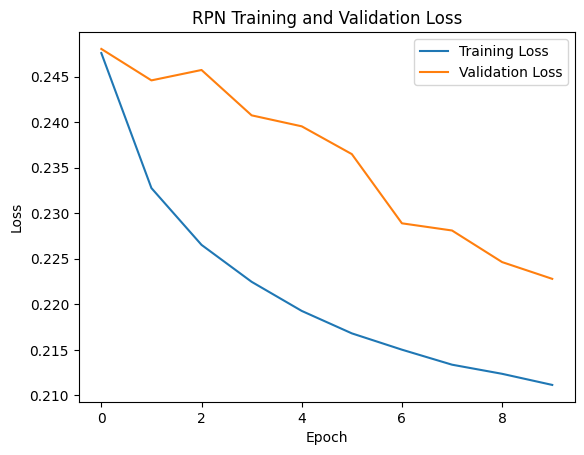

In [12]:
plt.plot(train_loss_history, label= "Training Loss")
plt.plot(val_loss_history, label= "Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("RPN Training and Validation Loss")
plt.legend()
plt.show()

In [13]:
all_test_images= [
    img for img in os.listdir(images_val_dir)
    if img.lower().endswith(valid_img_extensions) and os.path.exists(os.path.join(labels_2_dir, img.rsplit('.', 1)[0] + ".txt"))
]
test_dataset= FaceDataset(image_dir= images_val_dir, label_dir= labels_2_dir, image_list= all_test_images, transform= transforms)
test_loader= DataLoader(test_dataset, batch_size= 8, shuffle= False, collate_fn= roi_collate)

In [14]:
test_cls_epoch, test_reg_epoch, test_total_loss_epoch= 0.0, 0.0, 0.0
test_num_batches= 0.0
backbone.eval()
rpn_model.eval()
roi_head.eval()
for epoch in range(1):
    with torch.no_grad():
        for batch in test_loader:
            images = torch.stack([b['image'] for b in batch]).to(device)
            gt_boxes = [b['boxes'].to(device) for b in batch]

            B, _, H, W = images.shape
            image_shapes = [(H, W)] * B
            proposals, features = generate_proposals(images, image_shapes)

            roi_out = roi_head(features, proposals, image_shapes, gt_boxes)
            test_cls_epoch += roi_out['cls_loss'].item()
            test_reg_epoch += roi_out['reg_loss'].item()
            test_num_batches += 1

    test_cls_epoch /= test_num_batches
    test_reg_epoch /= test_num_batches
    test_total_loss = test_cls_epoch + test_reg_epoch

    # Compute mAP every few epochs
    all_pred_boxes, all_pred_scores, all_gt_boxes = evaluate_model(
        roi_head, backbone, rpn_model, test_loader, device
    )
    results = compute_map(all_pred_boxes, all_pred_scores, all_gt_boxes, iou_thresh=0.5)

    print(f"Epoch {epoch + 1}/{config.NUM_EPOCHS}:")
    print(f"Val:- Objectness Loss: {test_cls_epoch:.4f}, Reg Loss: {test_reg_epoch:.4f}, Total Loss: {test_total_loss:.4f}")
    print(f"mAP Metrics - Precision: {results['precision']:.4f}, Recall: {results['recall']:.4f}, mAP: {results['map']:.4f}")

    print("-" * 50)

/tmp/ipython-input-3023498800.py:4: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1/10:
Val:- Objectness Loss: 0.2164, Reg Loss: 0.0036, Total Loss: 0.2199
mAP Metrics - Precision: 0.9085, Recall: 0.4521, mAP: 0.7467
--------------------------------------------------


In [53]:
@torch.no_grad()
def roi_head_inference(features, proposals, image_shape, roi_head, score_thresh= 0.5, nms_thresh= 0.1):
    roi_out= roi_head(features, [proposals], [image_shape], gt_boxes= None)
    cls_logits= roi_out['cls_logits']
    bbox_deltas= roi_out['bbox_deltas']

    print("cls_logits range:", cls_logits.min().item(), cls_logits.max().item())
    scores= F.softmax(cls_logits, dim= 1)[:, 1]
    print(scores.max())
    pred_boxes= apply_deltas_to_boxes(proposals, bbox_deltas)
    pred_boxes= clamp_boxes_to_img_boundary(pred_boxes, image_shape)

    keep= scores > score_thresh
    pred_boxes= pred_boxes[keep]
    scores= scores[keep]

    keep= nms(pred_boxes, scores, nms_thresh)
    return pred_boxes[keep], scores[keep]


/tmp/ipython-input-3023498800.py:4: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


cls_logits range: -1.6158497333526611 1.5729024410247803
tensor(0.9572, device='cuda:0')


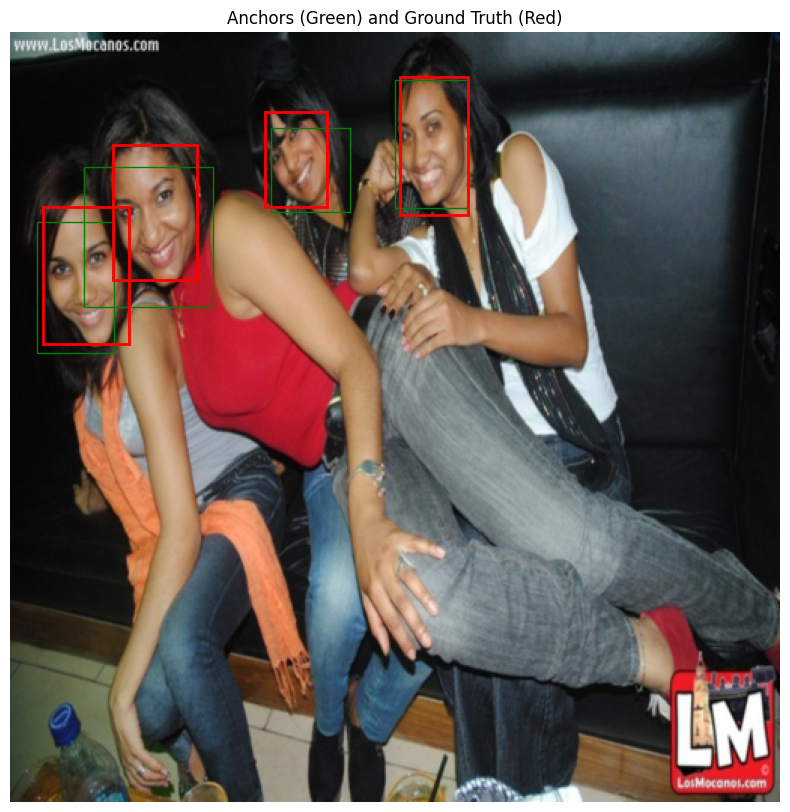

In [74]:
sample_image= test_dataset[1000]['image'].unsqueeze(0).to(device)
sample_label= test_dataset[1000]['boxes']

B, _, H, W= sample_image.shape
image_shapes= [(H, W)]

proposals, features= generate_proposals(sample_image, image_shapes)
proposals= proposals[0]
features= features.to(device)

pred_boxes, pred_scores= roi_head_inference(features, proposals, (H, W), roi_head)
gt_boxes= filter_valid_bboxes(sample_label)
visualize_anchors_and_gt(sample_image.squeeze(0), pred_boxes.cpu(), sample_label)

In [20]:
torch.save(roi_head.state_dict(), artifacts_dir + "roi_10eps_rpns2r1_2048fc_512p_07fg_015val_wghts.pth")

In [18]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
!cp /content/artifacts/roi_10eps_rpns2r1_2048fc_512p_07fg_015val_wghts.pth "/content/drive/MyDrive/Face-Detection/models"